## Customer Churn in Telecom Industry

## Pre-Importing Certain Libraries

In [ ]:
# Customer Churn Prediction in Telecom Industry
from typing import Literal
import kagglehub
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Statistical tests
from scipy.stats import chi2_contingency, f_oneway
from scipy.stats import pearsonr

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Resampling techniques
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE

# Machine Learning Models
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
R_SEED = 42
np.random.seed(R_SEED)
tf.random.set_seed(R_SEED)

In [ ]:
FIGURE_INTERACTIVE = False

from IPython.display import Image
def display_fig(fig):
  """
  Helper function to display plotly figures in Colab or PDF file as image
  Args:
    fig: The plotly figure to display.
  """
  if FIGURE_INTERACTIVE:
    fig.show()
  else:
    fig_img = fig.to_image(format="png")
    display(Image(fig_img))

## Problem Statement: Customer Churn in Telecom Industry

### Understanding Customer Churn

**Customer churn**, also known as customer attrition, refers to the phenomenon where customers stop using a company's services or products. In the telecommunications industry, churn is a critical business metric as:

- **High acquisition costs**: Acquiring new customers is typically 5-7 times more expensive than retaining existing ones
- **Revenue impact**: Churn directly affects monthly recurring revenue (MRR) and lifetime customer value (LTV)
- **Competitive market**: The telecom industry is highly competitive with low switching barriers
- **Predictability**: Churn often follows patterns that can be identified through data analysis

### Business Impact

- **Financial Loss**: Every churned customer represents lost revenue and wasted acquisition investment
- **Market Share**: High churn rates can lead to declining market position
- **Customer Experience**: Understanding churn drivers helps improve overall service quality
- **Proactive Retention**: Predictive models enable targeted retention campaigns

### Objective

Our goal is to build a Aritificial Neural Network model that can:
1. Predict which customers are likely to churn
2. Identify key factors driving customer attrition
3. Enable proactive retention strategies
4. Provide user-friendly Streamlit interface to provide actionable insights for business decision-making


## Dataset Analysis and Preprocessing

### Download Dataset from Kaggle

In [ ]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Dataset downloaded successfully!")

# Load the dataset
raw_df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = raw_df.copy()

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset downloaded successfully!
Dataset loaded successfully!
Dataset shape: (7043, 21)


### Dataset Overview

In [ ]:
print("=== DATASET OVERVIEW ===")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic information
print("\n=== COLUMN INFORMATION ===")
print(df.info())

print("\n=== FIRST FEW ROWS ===")
display(df.head())

=== DATASET OVERVIEW ===
Number of rows: 7,043
Number of columns: 21
Memory usage: 7.79 MB

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies  

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Column Descriptions

**Customer Demographics:**
- `CustomerID`: Unique identifier for each customer
- `Gender`: Customer's gender (Male/Female)
- `SeniorCitizen`: Whether customer is senior citizen (0/1)
- `Partner`: Whether customer has a partner (Yes/No)
- `Dependents`: Whether customer has dependents (Yes/No)

**Phone Services:**
- `PhoneService`: Whether customer has phone service (Yes/No)
- `MultipleLines`: Whether customer has multiple lines (Yes/No/No phone service)

**Internet Services:**
- `InternetService`: Customer's internet service provider (DSL/Fiber optic/No)
- `OnlineSecurity`: Whether customer has online security (Yes/No/No internet service)
- `OnlineBackup`: Whether customer has online backup (Yes/No/No internet service)
- `DeviceProtection`: Whether customer has device protection (Yes/No/No internet service)
- `TechSupport`: Whether customer has tech support (Yes/No/No internet service)
- `StreamingTV`: Whether customer has streaming TV (Yes/No/No internet service)
- `StreamingMovies`: Whether customer has streaming movies (Yes/No/No internet service)

**Contract Details:**
- `Contract`: Contract term (Month-to-month/One year/Two year)
- `PaperlessBilling`: Whether customer has paperless billing (Yes/No)
- `PaymentMethod`: Payment method (Electronic check/Mailed check/Bank transfer/Credit card)

**Financial Information:**
- `Tenure`: Number of months customer has stayed with company
- `MonthlyCharges`: Monthly charge amount
- `TotalCharges`: Total amount charged to customer
- `Churn`: Whether customer churned (Yes/No) - **TARGET VARIABLE**


### Data Quality Assessment

In [ ]:
print("=== DATA QUALITY ASSESSMENT ===")

# Check for missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Check data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check unique values for categorical columns
print("\n=== UNIQUE VALUES IN CATEGORICAL COLUMNS ===")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Values: {df[col].unique()[:10]}")  # Show first 10 unique values
    print()

=== DATA QUALITY ASSESSMENT ===
Missing values per column:
Series([], dtype: int64)

=== DATA TYPES ===
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Duplicate rows: 0

=== UNIQUE VALUES IN CATEGORICAL COLUMNS ===
customerID: 7043 unique values
Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU']

gender: 2 unique values
Values: ['Female' 'Male']

Partn

### Data Cleaning

In [ ]:
# 1. Fix TotalCharges data type
print("=== FIXING TOTALCHARGES DATA TYPE ===")
print(f"TotalCharges dtype before: {df['TotalCharges'].dtype}")

# Replace empty strings with NaN and convert to float
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(float)
print(f"TotalCharges dtype after: {df['TotalCharges'].dtype}")

# 2. Convert SeniorCitizen to categorical
print("\n=== CONVERTING SENIORCITIZEN TO CATEGORICAL ===")
print(f"SeniorCitizen unique values before: {df['SeniorCitizen'].unique()}")
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1: "Yes", 0: "No"})
print(f"SeniorCitizen unique values after: {df['SeniorCitizen'].unique()}")

=== FIXING TOTALCHARGES DATA TYPE ===
TotalCharges dtype before: object
TotalCharges dtype after: float64

=== CONVERTING SENIORCITIZEN TO CATEGORICAL ===
SeniorCitizen unique values before: [0 1]
SeniorCitizen unique values after: ['No' 'Yes']


In [ ]:
# 3. Handle missing values
print("=== HANDLING MISSING VALUES ===")
print(f"Rows with missing TotalCharges: {df['TotalCharges'].isnull().sum()}")
print(f"Percentage of missing data: {df['TotalCharges'].isnull().sum() / len(df) * 100:.2f}%")

# Since it's a small percentage, we'll drop these rows
df.dropna(inplace=True)
print(f"Dataset shape after dropping missing values: {df.shape}")

=== HANDLING MISSING VALUES ===
Rows with missing TotalCharges: 11
Percentage of missing data: 0.16%
Dataset shape after dropping missing values: (7032, 21)


In [ ]:
# 4. Standardize categorical values
print("=== STANDARDIZING CATEGORICAL VALUES ===")
print("Replacing 'No internet service' and 'No phone service' with 'No'")
print("Reasoning: These values logically mean the same as 'No' for the respective services")

# Services that can have "No internet service"
internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in internet_service_cols:
    print(f"Before - {col}: {df[col].value_counts().to_dict()}")
    df[col] = df[col].replace({"No internet service": "No"})
    print(f"After - {col}: {df[col].value_counts().to_dict()}")
    print()

# MultipleLines can have "No phone service"
print(f"Before - MultipleLines: {df['MultipleLines'].value_counts().to_dict()}")
df['MultipleLines'] = df['MultipleLines'].replace({"No phone service": "No"})
print(f"After - MultipleLines: {df['MultipleLines'].value_counts().to_dict()}")

print(f"\nFinal dataset shape: {df.shape}")

=== STANDARDIZING CATEGORICAL VALUES ===
Replacing 'No internet service' and 'No phone service' with 'No'
Reasoning: These values logically mean the same as 'No' for the respective services
Before - OnlineSecurity: {'No': 3497, 'Yes': 2015, 'No internet service': 1520}
After - OnlineSecurity: {'No': 5017, 'Yes': 2015}

Before - OnlineBackup: {'No': 3087, 'Yes': 2425, 'No internet service': 1520}
After - OnlineBackup: {'No': 4607, 'Yes': 2425}

Before - DeviceProtection: {'No': 3094, 'Yes': 2418, 'No internet service': 1520}
After - DeviceProtection: {'No': 4614, 'Yes': 2418}

Before - TechSupport: {'No': 3472, 'Yes': 2040, 'No internet service': 1520}
After - TechSupport: {'No': 4992, 'Yes': 2040}

Before - StreamingTV: {'No': 2809, 'Yes': 2703, 'No internet service': 1520}
After - StreamingTV: {'No': 4329, 'Yes': 2703}

Before - StreamingMovies: {'No': 2781, 'Yes': 2731, 'No internet service': 1520}
After - StreamingMovies: {'No': 4301, 'Yes': 2731}

Before - MultipleLines: {'No': 338

## Exploratory Data Analysis (EDA)


### Create Distribution Plots for all Columns

In [ ]:
def plot_distributions(df: pd.DataFrame):
    """
    Plot distributions for all variables with Plotly.
    Args:
        df: The pandas DataFrame containing the data.
    """

    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Remove CustomerID and Churn from categorical if present
    if 'customerID' in categorical_cols:
        categorical_cols.remove('customerID')
    if 'Churn' in categorical_cols:
        categorical_cols.remove('Churn')

    print("=== NUMERIC VARIABLES DISTRIBUTION ===")

    # Numeric distributions
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=numeric_cols,
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    for i, col in enumerate(numeric_cols):
        row = i // 2 + 1
        col_pos = i % 2 + 1

        fig.add_trace(
            go.Histogram(x=df[col], name=col, nbinsx=30),
            row=row, col=col_pos
        )

    fig.update_layout(height=600, width=1000, title_text="Distribution of Numeric Variables")
    display_fig(fig)

    print("\n=== CATEGORICAL VARIABLES DISTRIBUTION ===")

    # Categorical distributions
    n_cols = len(categorical_cols)
    n_rows = (n_cols + 2) // 3  # 3 columns per row

    fig = make_subplots(
        rows=n_rows, cols=3,
        subplot_titles=categorical_cols,
        specs=[[{"type": "bar"}] * 3 for _ in range(n_rows)]
    )

    for i, col in enumerate(categorical_cols):
        row = i // 3 + 1
        col_pos = i % 3 + 1

        value_counts = df[col].value_counts()

        fig.add_trace(
            go.Bar(x=value_counts.index, y=value_counts.values, name=col),
            row=row, col=col_pos
        )

    fig.update_layout(height=200*n_rows, width=1000, title_text="Distribution of Categorical Variables")
    display_fig(fig)

=== NUMERIC VARIABLES DISTRIBUTION ===


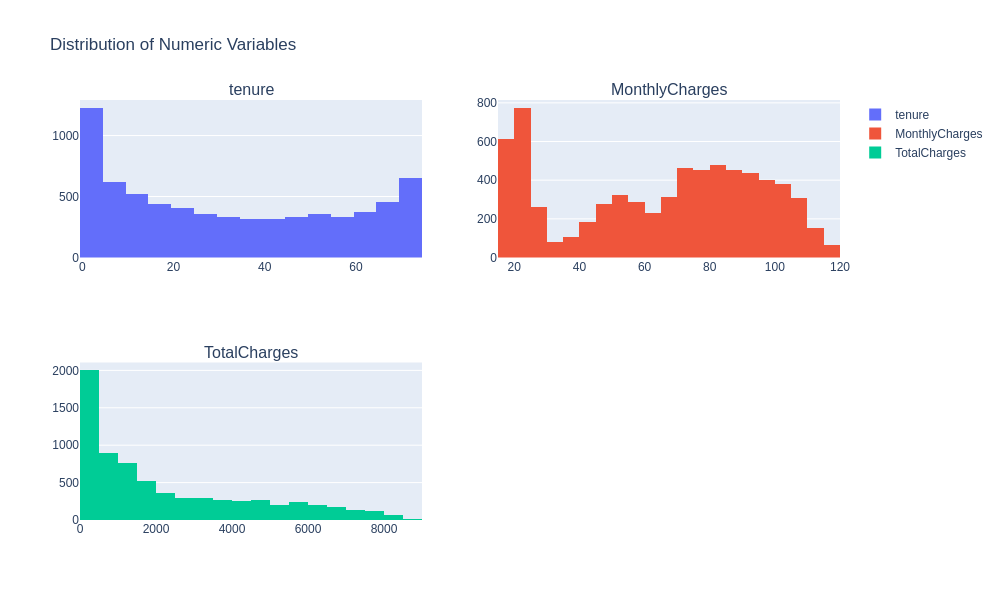


=== CATEGORICAL VARIABLES DISTRIBUTION ===


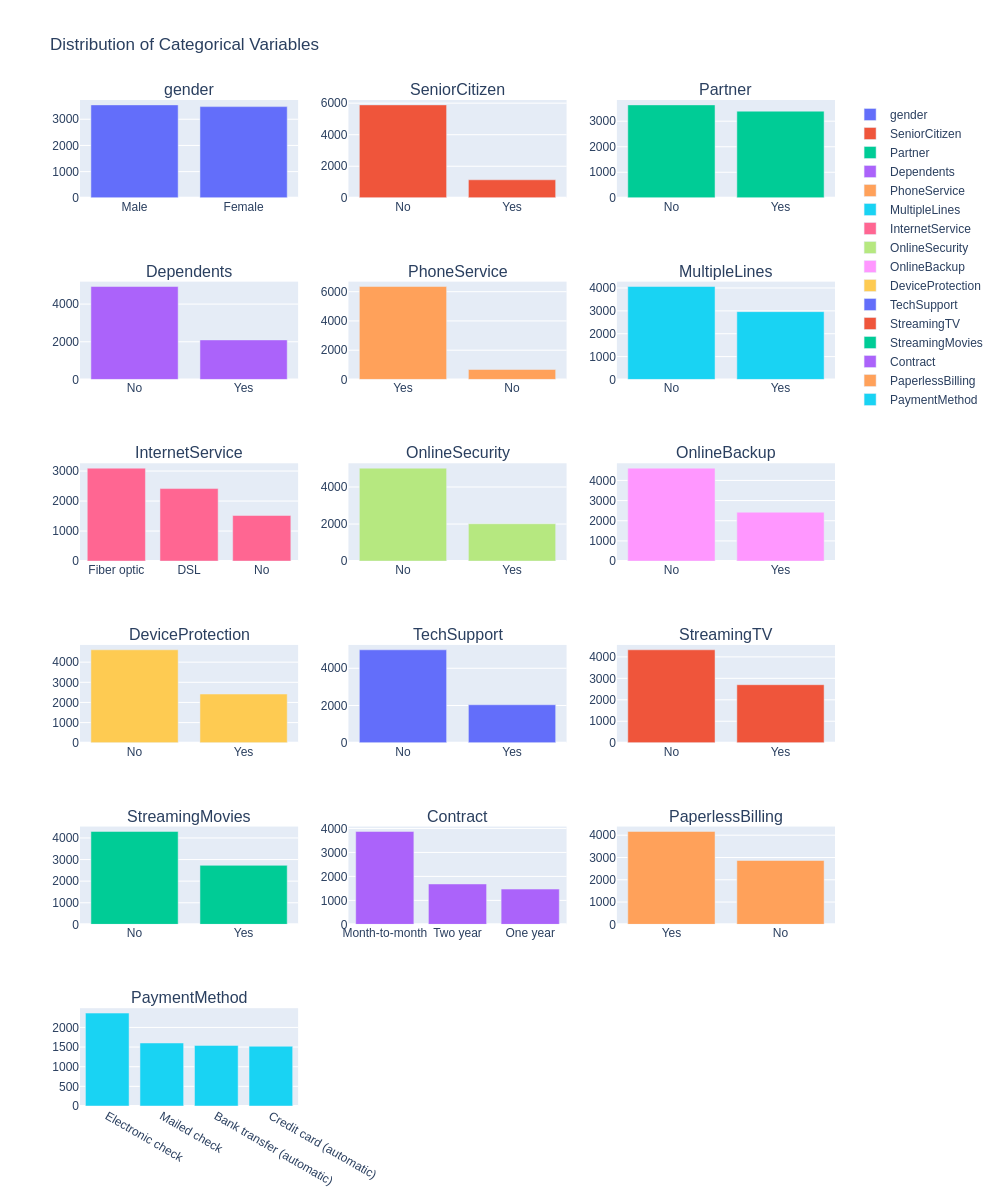

In [ ]:
# Execute distribution analysis
plot_distributions(df)

### Target Variable Analysis (Class Imbalance)


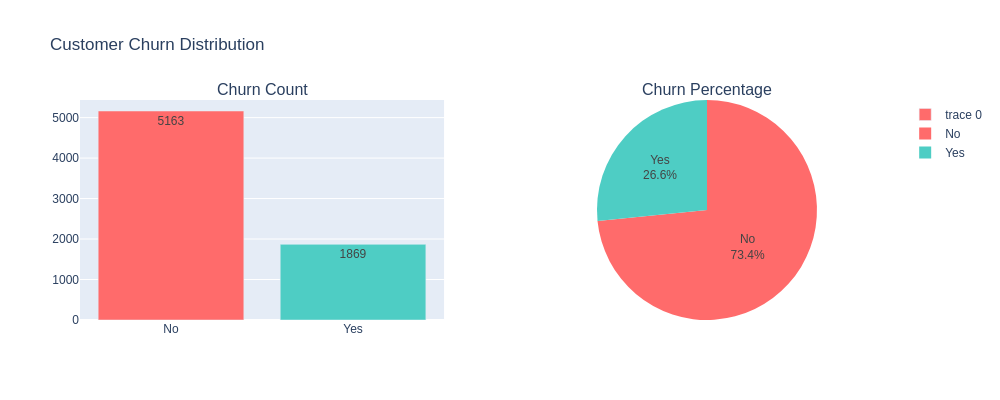

In [ ]:
# Analyze churn distribution
churn_counts = df['Churn'].value_counts()
churn_percentages = df['Churn'].value_counts(normalize=True) * 100

# Visualize class imbalance
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "bar"}, {"type": "pie"}]],
    subplot_titles=["Churn Count", "Churn Percentage"]
)

# Bar plot
fig.add_trace(
    go.Bar(
        x=churn_counts.index,
        y=churn_counts.values,
        text=churn_counts.values,
        textposition='auto',
        marker_color=['#FF6B6B', '#4ECDC4']
    ),
    row=1, col=1
)

# Pie chart
fig.add_trace(
    go.Pie(
        labels=churn_percentages.index,
        values=churn_percentages.values,
        textinfo='label+percent',
        marker_colors=['#FF6B6B', '#4ECDC4']
    ),
    row=1, col=2
)

fig.update_layout(title_text="Customer Churn Distribution", height=400, width=1000)
display_fig(fig)

### Bivariate Analysis: Churn vs Features

#### analyze_churn_by_feature() Function


In [ ]:
def analyze_churn_by_feature(
    df: pd.DataFrame,
    feature: str,
    feature_type: Literal['categorical', 'numeric'] = 'categorical'
):
    """
    Analyze churn rate by different features.
    Args:
        df: The pandas DataFrame containing the data.
        feature: The feature to analyze.
        feature_type: The type of feature (categorical or numeric).
    """

    if feature_type == 'categorical':
        # Cross-tabulation
        crosstab = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100

        # Visualization
        fig = go.Figure()

        categories = crosstab.index
        churn_rates = crosstab['Yes']
        retention_rates = crosstab['No']

        fig.add_trace(go.Bar(
            name='Retained',
            x=categories,
            y=retention_rates,
            marker_color='#4ECDC4'
        ))

        fig.add_trace(go.Bar(
            name='Churned',
            x=categories,
            y=churn_rates,
            marker_color='#FF6B6B'
        ))

        fig.update_layout(
            title=f'Churn Rate by {feature}',
            xaxis_title=feature,
            yaxis_title='Percentage',
            barmode='stack',
            height=400,
            width=1000
        )

        display_fig(fig)

        # Print statistics
        print(f"\n=== CHURN ANALYSIS FOR {feature.upper()} ===")
        actual_counts = pd.crosstab(df[feature], df['Churn'])
        print("Actual counts:")
        print(actual_counts)
        print("\nChurn rates (%):")
        print(crosstab['Yes'].round(1))

    elif feature_type == 'numeric':
        # Box plot
        fig = go.Figure()

        for churn_status in ['No', 'Yes']:
            data = df[df['Churn'] == churn_status][feature]
            fig.add_trace(go.Box(
                y=data,
                name=f'Churn: {churn_status}',
                marker_color='#4ECDC4' if churn_status == 'No' else '#FF6B6B'
            ))

        fig.update_layout(
            title=f'Distribution of {feature} by Churn Status',
            yaxis_title=feature,
            height=400,
            width=1000
        )

        display_fig(fig)

        # Print statistics
        print(f"\n=== CHURN ANALYSIS FOR {feature.upper()} ===")
        stats = df.groupby('Churn')[feature].describe()
        print(stats.round(2))
        print()

#### Analyze Key Categorical Features

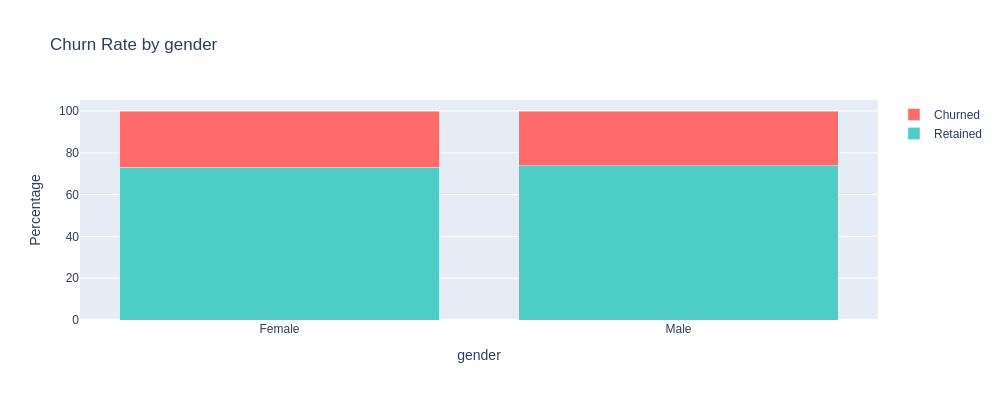


=== CHURN ANALYSIS FOR GENDER ===
Actual counts:
Churn     No  Yes
gender           
Female  2544  939
Male    2619  930

Churn rates (%):
gender
Female    27.0
Male      26.2
Name: Yes, dtype: float64


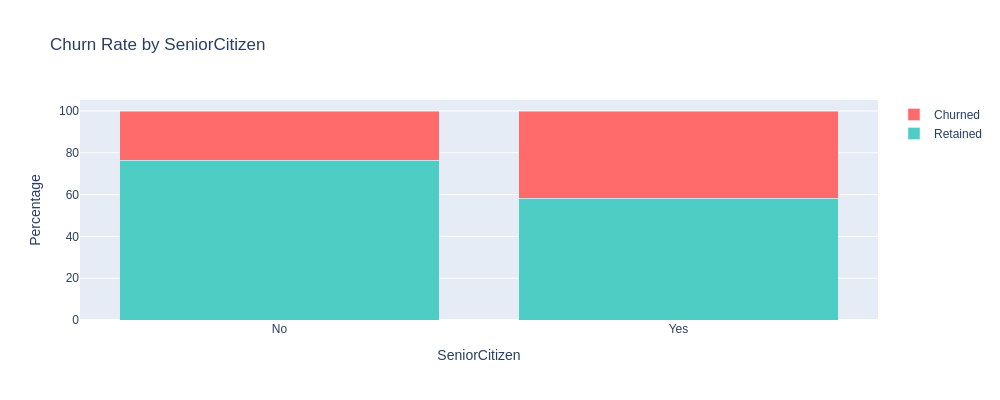


=== CHURN ANALYSIS FOR SENIORCITIZEN ===
Actual counts:
Churn            No   Yes
SeniorCitizen            
No             4497  1393
Yes             666   476

Churn rates (%):
SeniorCitizen
No     23.7
Yes    41.7
Name: Yes, dtype: float64


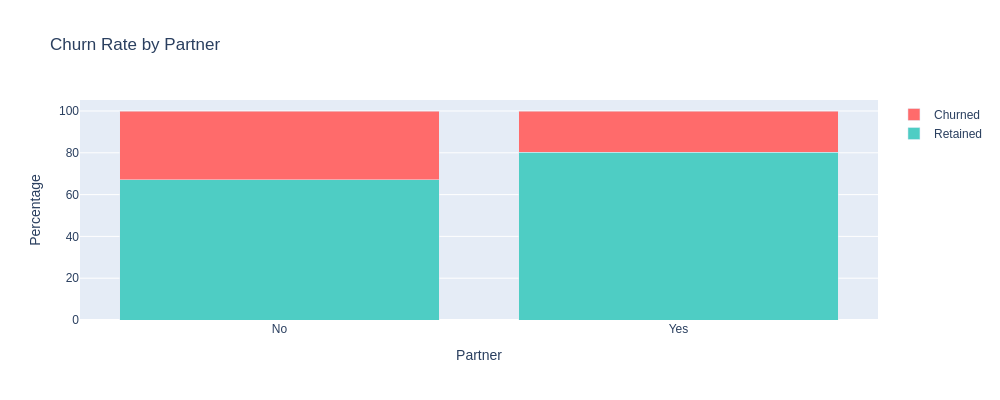


=== CHURN ANALYSIS FOR PARTNER ===
Actual counts:
Churn      No   Yes
Partner            
No       2439  1200
Yes      2724   669

Churn rates (%):
Partner
No     33.0
Yes    19.7
Name: Yes, dtype: float64


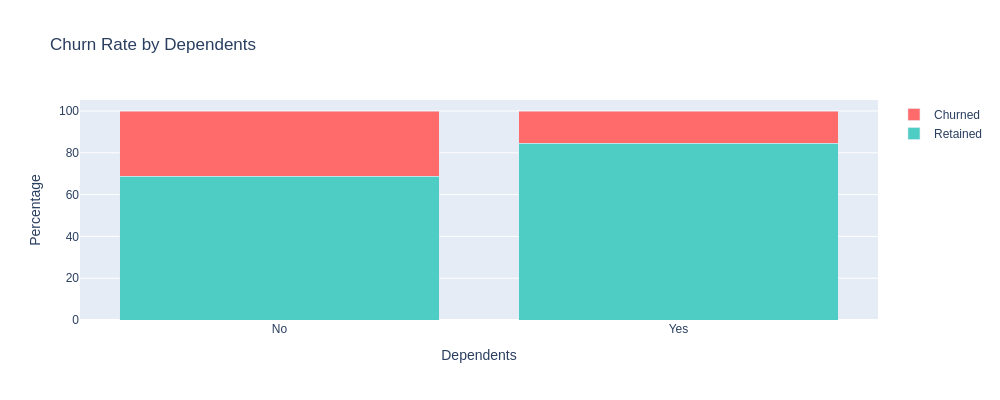


=== CHURN ANALYSIS FOR DEPENDENTS ===
Actual counts:
Churn         No   Yes
Dependents            
No          3390  1543
Yes         1773   326

Churn rates (%):
Dependents
No     31.3
Yes    15.5
Name: Yes, dtype: float64


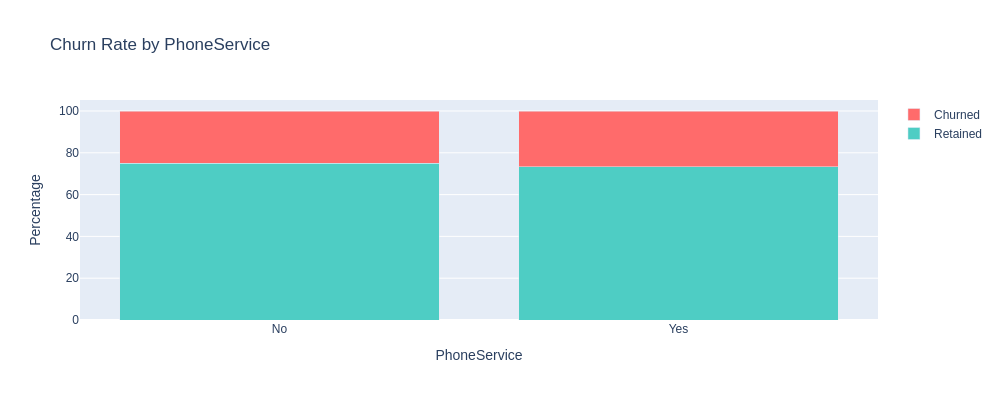


=== CHURN ANALYSIS FOR PHONESERVICE ===
Actual counts:
Churn           No   Yes
PhoneService            
No             510   170
Yes           4653  1699

Churn rates (%):
PhoneService
No     25.0
Yes    26.7
Name: Yes, dtype: float64


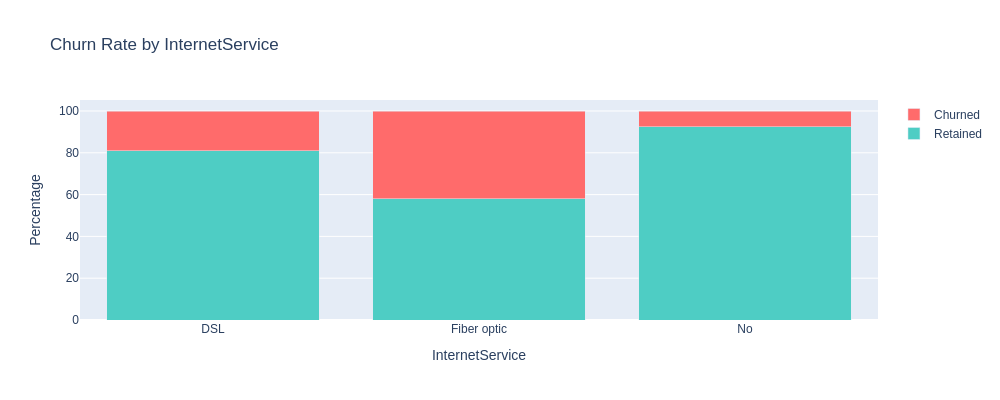


=== CHURN ANALYSIS FOR INTERNETSERVICE ===
Actual counts:
Churn              No   Yes
InternetService            
DSL              1957   459
Fiber optic      1799  1297
No               1407   113

Churn rates (%):
InternetService
DSL            19.0
Fiber optic    41.9
No              7.4
Name: Yes, dtype: float64


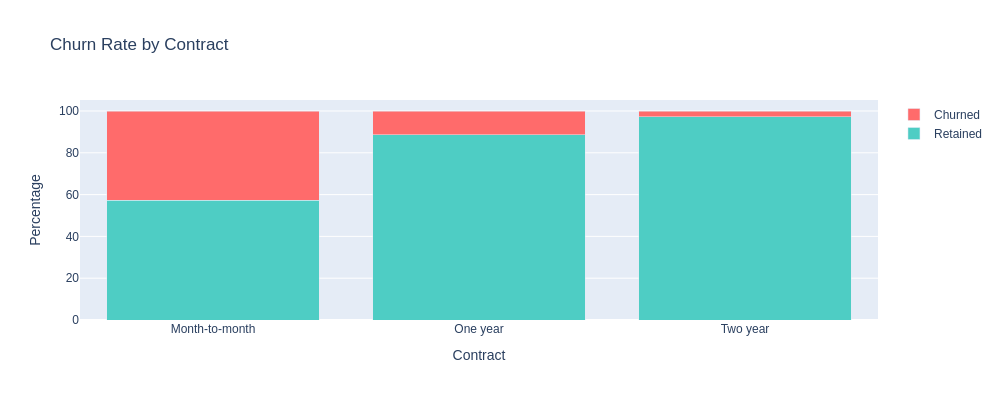


=== CHURN ANALYSIS FOR CONTRACT ===
Actual counts:
Churn             No   Yes
Contract                  
Month-to-month  2220  1655
One year        1306   166
Two year        1637    48

Churn rates (%):
Contract
Month-to-month    42.7
One year          11.3
Two year           2.8
Name: Yes, dtype: float64


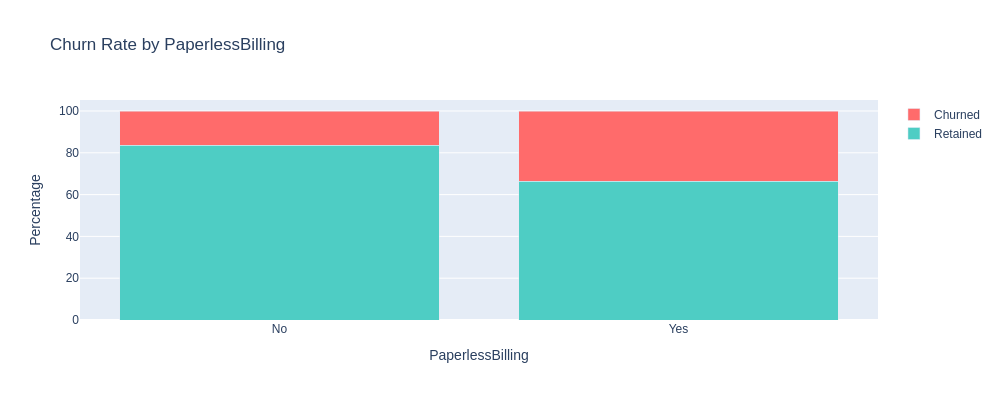


=== CHURN ANALYSIS FOR PAPERLESSBILLING ===
Actual counts:
Churn               No   Yes
PaperlessBilling            
No                2395   469
Yes               2768  1400

Churn rates (%):
PaperlessBilling
No     16.4
Yes    33.6
Name: Yes, dtype: float64


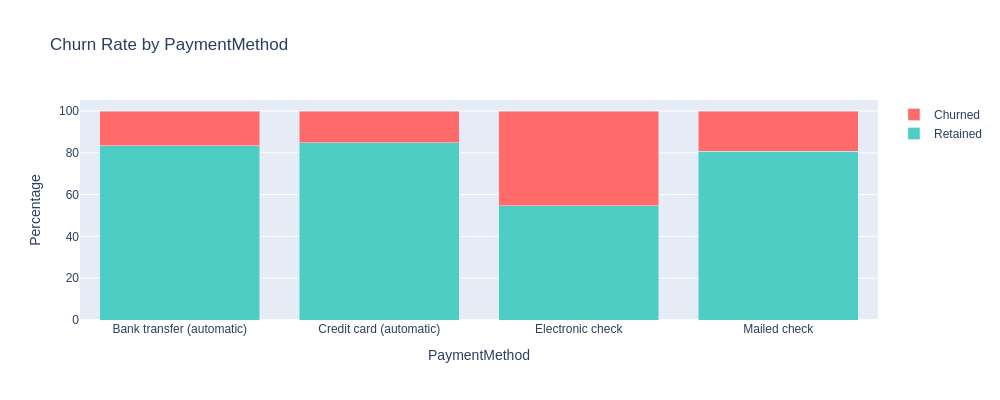


=== CHURN ANALYSIS FOR PAYMENTMETHOD ===
Actual counts:
Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  1284   258
Credit card (automatic)    1289   232
Electronic check           1294  1071
Mailed check               1296   308

Churn rates (%):
PaymentMethod
Bank transfer (automatic)    16.7
Credit card (automatic)      15.3
Electronic check             45.3
Mailed check                 19.2
Name: Yes, dtype: float64


In [ ]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'InternetService', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

for feature in categorical_features:
    analyze_churn_by_feature(df, feature, 'categorical')

#### Analyze Numeric Features

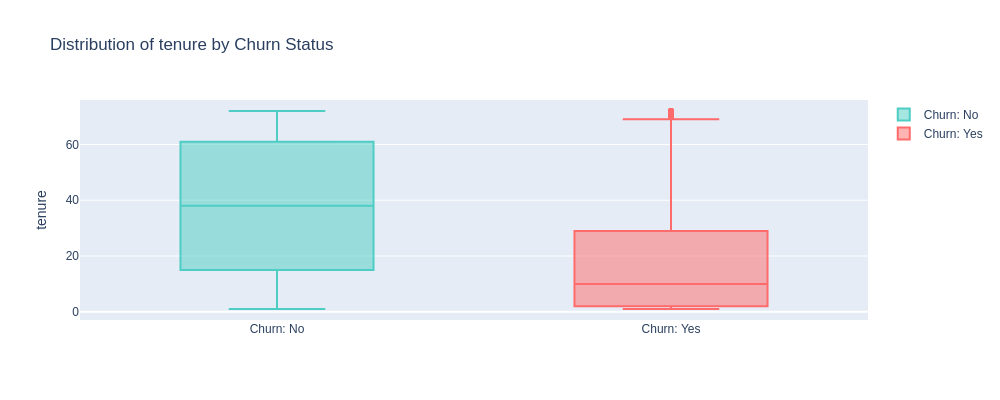


=== CHURN ANALYSIS FOR TENURE ===
        count   mean    std  min   25%   50%   75%   max
Churn                                                   
No     5163.0  37.65  24.08  1.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0



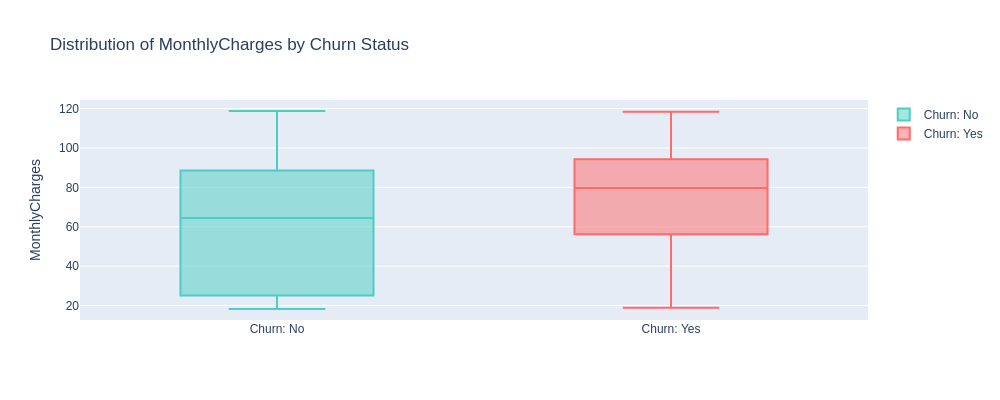


=== CHURN ANALYSIS FOR MONTHLYCHARGES ===
        count   mean    std    min    25%    50%    75%     max
Churn                                                          
No     5163.0  61.31  31.09  18.25  25.10  64.45  88.48  118.75
Yes    1869.0  74.44  24.67  18.85  56.15  79.65  94.20  118.35



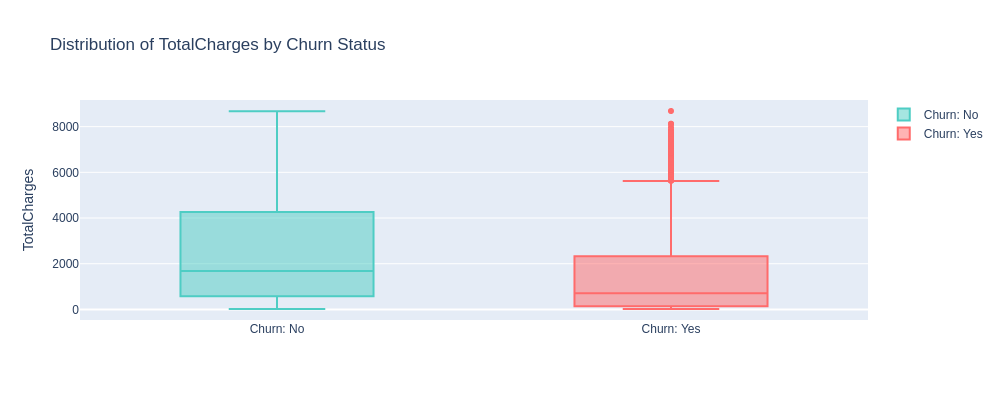


=== CHURN ANALYSIS FOR TOTALCHARGES ===
        count     mean      std    min     25%      50%      75%      max
Churn                                                                    
No     5163.0  2555.34  2329.46  18.80  577.83  1683.60  4264.12  8672.45
Yes    1869.0  1531.80  1890.82  18.85  134.50   703.55  2331.30  8684.80



In [ ]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for feature in numeric_features:
    analyze_churn_by_feature(df, feature, 'numeric')

### Correlation Analysis


In [ ]:
# Prepare data for correlation analysis
df_encoded = df.drop("customerID", axis=1).copy()

# Encode categorical variables for correlation analysis
label_encoders = {}
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

for col in categorical_cols:
  le = LabelEncoder()
  df_encoded[col] = le.fit_transform(df_encoded[col])
  label_encoders[col] = le

# Calculate correlation matrix
correlation_matrix = df_encoded.corr()

#### Plot Correlation Heatmap

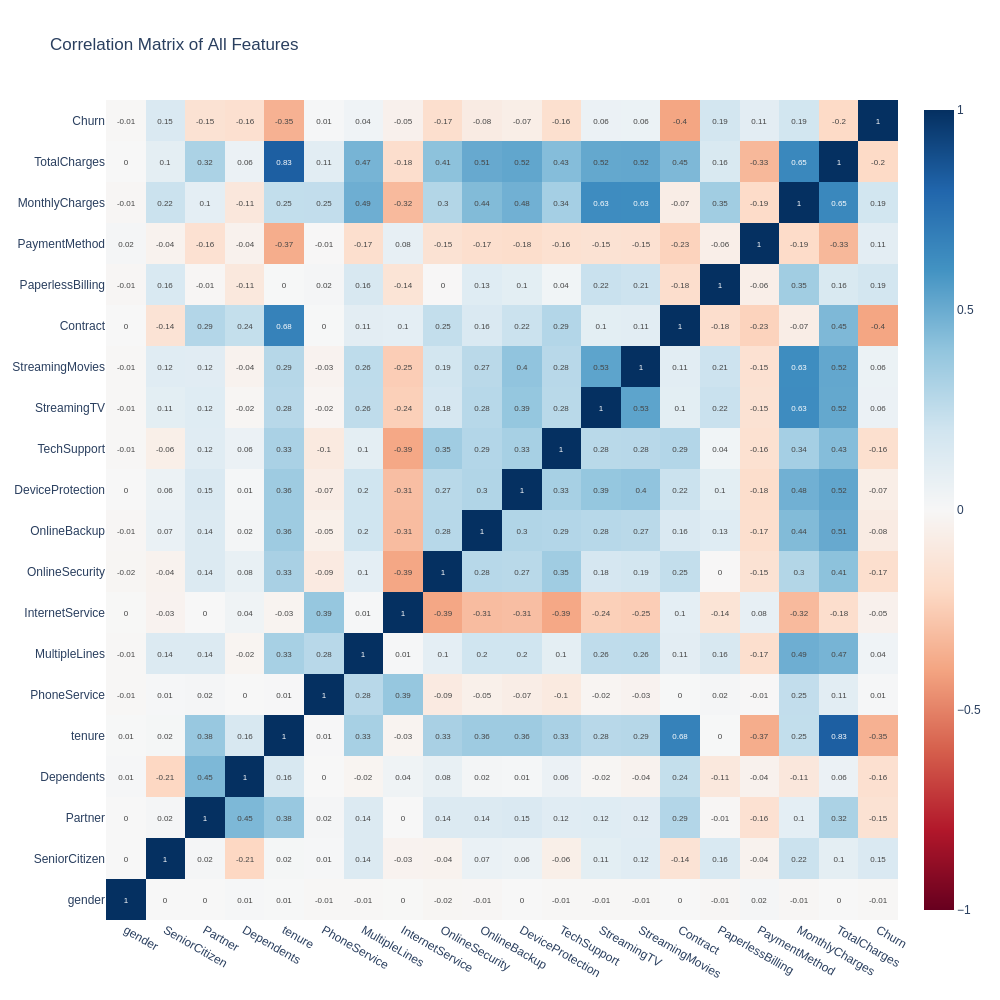

=== CORRELATIONS WITH CHURN (ABSOLUTE VALUES) ===
Churn               1.000
Contract            0.396
tenure              0.354
TotalCharges        0.199
MonthlyCharges      0.193
PaperlessBilling    0.191
OnlineSecurity      0.171
TechSupport         0.165
Dependents          0.163
SeniorCitizen       0.151
Partner             0.150
PaymentMethod       0.108
OnlineBackup        0.082
DeviceProtection    0.066
StreamingTV         0.063
StreamingMovies     0.061
InternetService     0.047
MultipleLines       0.040
PhoneService        0.012
gender              0.009
Name: Churn, dtype: float64


In [ ]:
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='RdBu',
    zmid=0,
    text=correlation_matrix.round(2).values,
    texttemplate="%{text}",
    textfont={"size": 8},
))

fig.update_layout(
    title='Correlation Matrix of All Features',
    height=1000,
    width=1000
)

display_fig(fig)

# Focus on correlations with Churn
churn_correlations = correlation_matrix['Churn'].abs().sort_values(ascending=False)
print("=== CORRELATIONS WITH CHURN (ABSOLUTE VALUES) ===")
print(churn_correlations.round(3))

#### Visualize Top Correlations with Churn

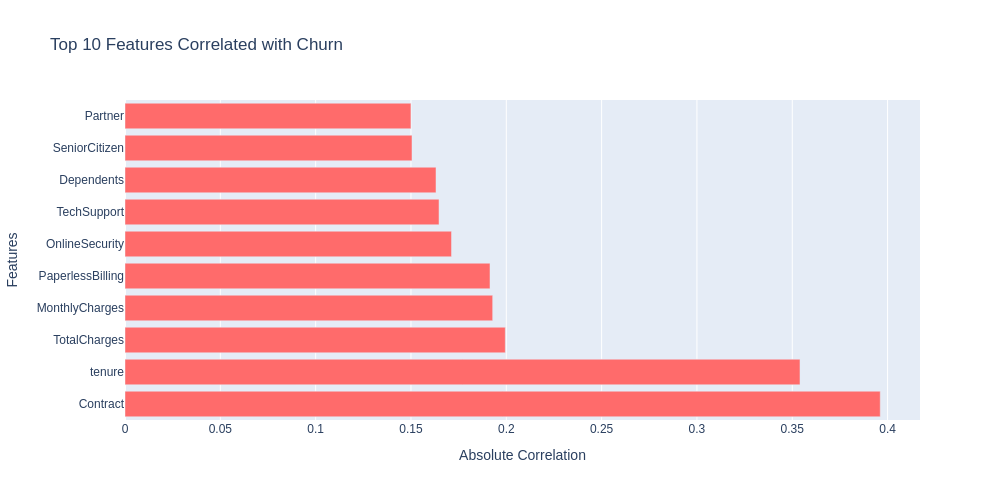

In [ ]:
top_correlations = churn_correlations[1:11]  # Exclude Churn itself

fig = go.Figure(go.Bar(
    x=top_correlations.values,
    y=top_correlations.index,
    orientation='h',
    marker_color='#FF6B6B'
))

fig.update_layout(
    title='Top 10 Features Correlated with Churn',
    xaxis_title='Absolute Correlation',
    yaxis_title='Features',
    height=500,
    width=1000
)

display_fig(fig)

### Statistical Tests


#### perform_statisitcal_tests() Function

In [ ]:

def perform_statistical_tests(df: pd.DataFrame):
    """
    Perform chi-square tests for categorical variables and ANOVA for numeric variables.
    Args:
        df: The pandas DataFrame containing the data.
    """

    print("=== STATISTICAL SIGNIFICANCE TESTS ===")

    # Chi-square tests for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col not in ['customerID', 'Churn']]

    print("\n--- CHI-SQUARE TESTS (Categorical vs Churn) ---")
    chi_square_results = []

    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df['Churn'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        chi_square_results.append({
            'Feature': col,
            'Chi2_Statistic': chi2,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

        print(f"{col}: Chi2={chi2:.3f}, p-value={p_value:.3e}, Significant: {'Yes' if p_value < 0.05 else 'No'}")

    # ANOVA tests for numeric variables
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    print("\n--- ANOVA TESTS (Numeric vs Churn) ---")
    anova_results = []

    for col in numeric_cols:
        churned = df[df['Churn'] == 'Yes'][col]
        not_churned = df[df['Churn'] == 'No'][col]

        f_stat, p_value = f_oneway(churned, not_churned)

        anova_results.append({
            'Feature': col,
            'F_Statistic': f_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

        print(f"{col}: F={f_stat:.3f}, p-value={p_value:.3e}, Significant: {'Yes' if p_value < 0.05 else 'No'}")

    return chi_square_results, anova_results

In [ ]:
# Perform statistical tests
chi_square_results, anova_results = perform_statistical_tests(df)

=== STATISTICAL SIGNIFICANCE TESTS ===

--- CHI-SQUARE TESTS (Categorical vs Churn) ---
gender: Chi2=0.475, p-value=4.905e-01, Significant: No
SeniorCitizen: Chi2=158.441, p-value=2.479e-36, Significant: Yes
Partner: Chi2=157.503, p-value=3.974e-36, Significant: Yes
Dependents: Chi2=186.322, p-value=2.020e-42, Significant: Yes
PhoneService: Chi2=0.874, p-value=3.499e-01, Significant: No
MultipleLines: Chi2=11.087, p-value=8.694e-04, Significant: Yes
InternetService: Chi2=728.696, p-value=5.831e-159, Significant: Yes
OnlineSecurity: Chi2=205.416, p-value=1.374e-46, Significant: Yes
OnlineBackup: Chi2=47.247, p-value=6.259e-12, Significant: Yes
DeviceProtection: Chi2=30.496, p-value=3.346e-08, Significant: Yes
TechSupport: Chi2=189.967, p-value=3.233e-43, Significant: Yes
StreamingTV: Chi2=27.842, p-value=1.316e-07, Significant: Yes
StreamingMovies: Chi2=25.764, p-value=3.858e-07, Significant: Yes
Contract: Chi2=1179.546, p-value=7.326e-257, Significant: Yes
PaperlessBilling: Chi2=256.87

## Data Preprocessing for Machine Learning

### Train-Test Split

In [ ]:
# Create additional features
df_ml = df.copy()

# Separate features and target
X = df_ml.drop(['Churn', 'customerID'], axis=1)
y = df_ml['Churn']

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("=== TARGET ENCODING ===")
print(f"Target classes: {le_target.classes_}")
print(f"Encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=R_SEED,
    stratify=y_encoded
)

print(f"\n=== TRAIN-TEST SPLIT ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print()
print(f"Training set churn rate: {y_train.mean():.3f}")
print(f"Test set churn rate: {y_test.mean():.3f}")

=== TARGET ENCODING ===
Target classes: ['No' 'Yes']
Encoding: {'No': np.int64(0), 'Yes': np.int64(1)}

=== TRAIN-TEST SPLIT ===
X_train shape: (5625, 19)
y_train shape: (5625,)
X_test shape: (1407, 19)
y_test shape: (1407,)

Training set churn rate: 0.266
Test set churn rate: 0.266


### Feature Preprocessing

In [ ]:
# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"=== FEATURE TYPES ===")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # We'll compare different scalers
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
num_feature_names = numeric_features
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = num_feature_names + list(cat_feature_names)

print(f"\n=== PREPROCESSING RESULTS ===")
print(f"Original features: {X_train.shape[1]}")
print(f"Features after preprocessing: {X_train_processed.shape[1]}")
print(f"Feature names sample: {all_feature_names[:10]}...")

=== FEATURE TYPES ===
Numeric features (3): ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (16): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

=== PREPROCESSING RESULTS ===
Original features: 19
Features after preprocessing: 23
Feature names sample: ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic']...


### Handling Class Imbalance with Resampling

In [ ]:
print("=== RESAMPLING TECHNIQUES ===")
print(f"Original training set distribution:")
print(f"Class 0 (No Churn): {(y_train == 0).sum()}")
print(f"Class 1 (Churn): {(y_train == 1).sum()}")

# Method 1: SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_processed, y_train)

print(f"\nAfter SMOTETomek:")
print(f"Class 0 (No Churn): {(y_train_smote_tomek == 0).sum()}")
print(f"Class 1 (Churn): {(y_train_smote_tomek == 1).sum()}")

# Method 2: SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_processed, y_train)

print(f"\nAfter SMOTEENN:")
print(f"Class 0 (No Churn): {(y_train_smote_enn == 0).sum()}")
print(f"Class 1 (Churn): {(y_train_smote_enn == 1).sum()}")

=== RESAMPLING TECHNIQUES ===
Original training set distribution:
Class 0 (No Churn): 4130
Class 1 (Churn): 1495

After SMOTETomek:
Class 0 (No Churn): 3973
Class 1 (Churn): 3973

After SMOTEENN:
Class 0 (No Churn): 2273
Class 1 (Churn): 2999


## Model Building and Training

### Model Architecture & Training Configuration Setup

In [ ]:
class TelcoChurnNeuralNetwork:
    def __init__(self, input_dim: int, title: str = '', model = None, history = None):
        """
        Initialize the neural network.
        Args:
            input_dim: Dimension of input features
            title: Model's title name
        """

        self.input_dim = input_dim
        self.title = title
        self.model = model
        self.history = history


    def build_model(self, num_layers=3):
        """
        Build the neural network.
        Args:
            nuy_layers: Number of hidden layers (default = 3)
        Returns:
            The built & compiled Keras sequential neural network model
        """

        self.model = models.Sequential()

        # Input layer
        self.model.add(layers.Input(shape=(self.input_dim,)))

        # First hidden layer
        self.model.add(layers.Dense(128, activation='relu'))
        self.model.add(layers.Dropout(0.3))

        # Extra hidden layers
        for i in range(num_layers - 1):
          self.model.add(layers.Dense(64, activation='relu'))
          self.model.add(layers.Dropout(0.1))

        # Output layer
        self.model.add(layers.Dense(1, activation='sigmoid'))

        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        return self.model


    def train_model(
          self,
          X_train, y_train,
          epochs: int = 50,
          batch_size: int = 32,
          validation_split: float = 0.2,
          validation_data = None,
          using_class_weight: bool = False,
          using_early_stopping: bool = True,
          using_reduce_lr: bool = True
        ):
        """
        Train the neural network.
        Args:
            X_train: Training data features
            y_train: Training data labels
            epochs: Number of training epochs (default = 50)
            batch_size: Batch size for training (default = 32)
            validation_split: Proportion of data to use for validation (default = 0.2)
            validation_data: Custom validation data, if provided, `validation_split` is ignored (default = None)
            using_class_weight: Whether to use class weights for training (default = False)
            using_early_stopping: Whether to use early stopping (default = True)
            using_reduce_lr: Whether to use learning rate reduction (default = True)
        Returns:
            The training history of the Keras model
        """

        print(f"\n=== TRAINING CONFIGURATION ===")
        print(f"Input dimension: {self.input_dim}")
        print(f"Epochs: {epochs}")
        print(f"Batch size: {batch_size}")

        if validation_data is not None:
            print(f"Validation data: {validation_data[0].shape}, {validation_data[1].shape}")
        else:
            print(f"Validation split: {validation_split}")

        # Calculate class weights for imbalanced dataset
        class_weight_dict = None
        if using_class_weight:
          class_weights = compute_class_weight(
              'balanced',
              classes=np.unique(y_train),
              y=y_train
          )
          class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
          print(f"Class weights: {class_weight_dict}")

        # Callbacks
        callbacks = []
        if using_early_stopping:
          early_stopping = EarlyStopping(
              monitor='val_loss',
              patience=10,
              restore_best_weights=True
          )
          callbacks.append(early_stopping)
          print(f"Early stopping callback: used")

        if using_reduce_lr:
          reduce_lr = ReduceLROnPlateau(
              monitor='val_loss',
              factor=0.2,
              patience=5
          )
          callbacks.append(reduce_lr)
          print(f"Reduce learning rate callback: used")

        print(f"\n=== MODEL SUMMARY ===")
        self.model.summary()
        print()

        # Train model with class weights
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            validation_data=validation_data,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )
        return self.history


    def plot_training_history(self, title=''):
        """
        Train the neural network.
        Args:
            title: Title of the plot
        """
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Loss', 'Accuracy', 'Precision', 'Recall'),
            vertical_spacing=0.1
        )

        epochs = list(range(1, len(self.history.history['loss']) + 1))

        # Loss
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['loss'], name='Train Loss'), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['val_loss'], name='Val Loss'), row=1, col=1)

        # Accuracy
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['accuracy'], name='Train Acc'), row=1, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['val_accuracy'], name='Val Acc'), row=1, col=2)

        # Precision
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['precision'], name='Train Prec'), row=2, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['val_precision'], name='Val Prec'), row=2, col=1)

        # Recall
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['recall'], name='Train Rec'), row=2, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=self.history.history['val_recall'], name='Val Rec'), row=2, col=2)

        fig.update_layout(title=title, height=600, width=1000)
        display_fig(fig)


    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation.
        Args:
            X_test: Test data features
            y_test: Test data labels
        Returns:
            A dictionary containing evaluation metrics
        """

        # Predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        print(f"\n=== {self.title} PERFORMANCE ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")

        # Classification report
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        fig = go.Figure(data=go.Heatmap(
            z=cm,
            x=['Predicted No Churn', 'Predicted Churn'],
            y=['Actual No Churn', 'Actual Churn'],
            colorscale='Blues',
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 20},
        ))

        fig.update_layout(
            title=f'Confusion Matrix - {self.title}',
            xaxis_title='Predicted',
            yaxis_title='Actual',
            height=600,
            width=600
        )

        display_fig(fig)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'cm': cm
        }

### Model Training

#### Model 1: Neural Network with Class Weights

In [ ]:
print("=== TRAINING MODEL 1: NN WITH CLASS WEIGHTS ===")

input_dim = X_train_processed.shape[1]
model1 = TelcoChurnNeuralNetwork(input_dim, title="Model 1: NN with Class Weights")

model1.build_model()
model1.train_model(
    X_train_processed, y_train,
    using_class_weight=True
)

=== TRAINING MODEL 1: NN WITH CLASS WEIGHTS ===

=== TRAINING CONFIGURATION ===
Input dimension: 23
Epochs: 50
Batch size: 32
Validation split: 0.2
Class weights: {0: np.float64(0.6809927360774818), 1: np.float64(1.8812709030100334)}
Early stopping callback: used
Reduce learning rate callback: used

=== MODEL SUMMARY ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,553 (60.75 KB)

 Trainable params: 15,553 (60.75 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6742 - loss: 0.5910 - precision: 0.4502 - recall: 0.7559 - val_accuracy: 0.7689 - val_loss: 0.4702 - val_precision: 0.5392 - val_recall: 0.7534 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7539 - loss: 0.5097 - precision: 0.5347 - recall: 0.7662 - val_accuracy: 0.7698 - val_loss: 0.4696 - val_precision: 0.5388 - val_recall: 0.7842 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7510 - loss: 0.5066 - precision: 0.5292 - recall: 0.7793 - val_accuracy: 0.7671 - val_loss: 0.4754 - val_precision: 0.5350 - val_recall: 0.7842 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7499 - loss: 0.4923 - precision: 0.5284 - recall: 0.7685 - val_accuracy: 0.7716 - val_loss: 0.4693 - val_precision: 0.5418 - val_recall: 0.7774 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accurac

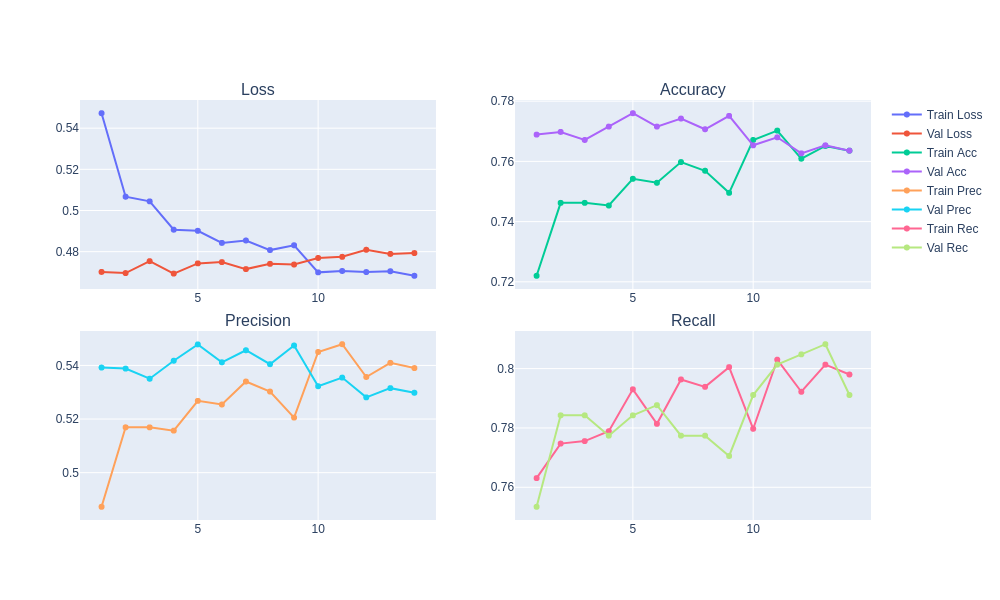

In [ ]:
# Plot training history
model1.plot_training_history()

#### Model 2: Neural Network with SMOTETomek


In [ ]:
print("=== TRAINING MODEL 2: NN WITH SMOTETOMEK ===")

# Split resampled data for validation
X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(
    X_train_smote_tomek, y_train_smote_tomek,
    test_size=0.2,
    random_state=R_SEED,
    stratify=y_train_smote_tomek
)

input_dim = X_train_sm.shape[1]
model2 = TelcoChurnNeuralNetwork(input_dim, title="Model 2: NN with SMOTETomek")

model2.build_model()
model2.train_model(
    X_train_sm, y_train_sm,
    validation_data=(X_val_sm, y_val_sm),
    using_class_weight=False,
)

=== TRAINING MODEL 2: NN WITH SMOTETOMEK ===

=== TRAINING CONFIGURATION ===
Input dimension: 23
Epochs: 50
Batch size: 32
Validation data: (1590, 23), (1590,)
Early stopping callback: used
Reduce learning rate callback: used

=== MODEL SUMMARY ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,553 (60.75 KB)

 Trainable params: 15,553 (60.75 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7204 - loss: 0.5527 - precision: 0.6994 - recall: 0.8054 - val_accuracy: 0.7975 - val_loss: 0.4481 - val_precision: 0.7895 - val_recall: 0.8113 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7936 - loss: 0.4612 - precision: 0.7777 - recall: 0.8252 - val_accuracy: 0.8013 - val_loss: 0.4377 - val_precision: 0.7960 - val_recall: 0.8101 - learning_rate: 0.0010
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7996 - loss: 0.4492 - precision: 0.7857 - recall: 0.8265 - val_accuracy: 0.8025 - val_loss: 0.4336 - val_precision: 0.7980 - val_recall: 0.8101 - learning_rate: 0.0010
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7937 - loss: 0.4428 - precision: 0.7853 - recall: 0.8113 - val_accuracy: 0.8013 - val_loss: 0.4328 - val_precision: 0.7924 - val_recall: 0.8164 - learning_rate: 0.0010
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

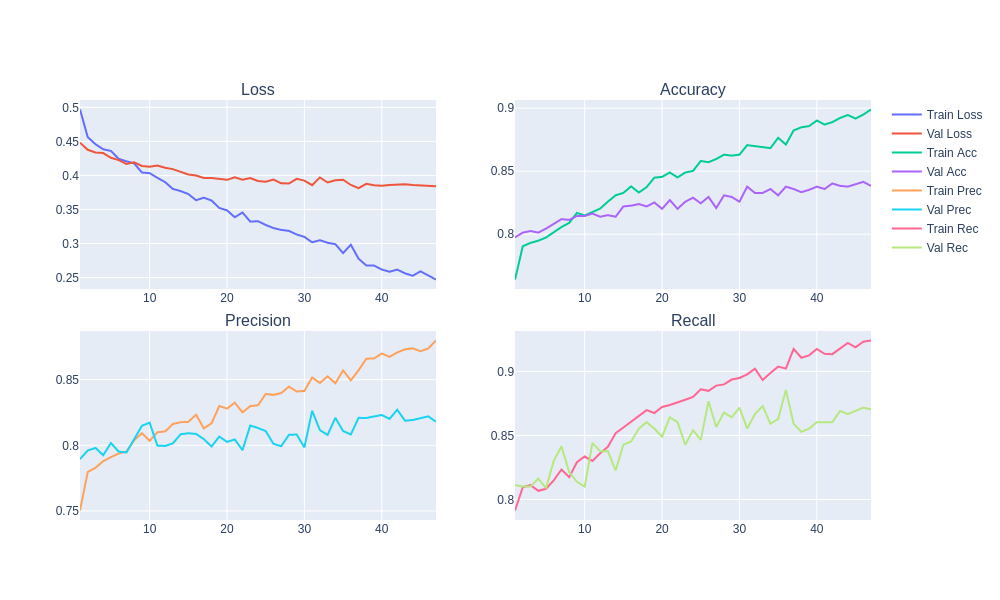

In [ ]:
# Plot training history
model2.plot_training_history()

#### Model 3: Neural Network with SMOTEENN


In [ ]:
print("\n=== TRAINING MODEL 3: NN WITH SMOTEENN ===")

# Split resampled data for validation
X_train_se, X_val_se, y_train_se, y_val_se = train_test_split(
    X_train_smote_enn, y_train_smote_enn,
    test_size=0.2,
    random_state=R_SEED,
    stratify=y_train_smote_enn
)

input_dim = X_train_se.shape[1]
model3 = TelcoChurnNeuralNetwork(input_dim, title="Model 3: NN with SMOTEENN")

model3.build_model()
model3.train_model(
    X_train_se, y_train_se,
    validation_data=(X_val_se, y_val_se),
    using_class_weight=False,
)


=== TRAINING MODEL 3: NN WITH SMOTEENN ===

=== TRAINING CONFIGURATION ===
Input dimension: 23
Epochs: 50
Batch size: 32
Validation data: (1055, 23), (1055,)
Early stopping callback: used
Reduce learning rate callback: used

=== MODEL SUMMARY ===


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,553 (60.75 KB)

 Trainable params: 15,553 (60.75 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7908 - loss: 0.4295 - precision: 0.7713 - recall: 0.9378 - val_accuracy: 0.9071 - val_loss: 0.2362 - val_precision: 0.9343 - val_recall: 0.9000 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9152 - loss: 0.2126 - precision: 0.9292 - recall: 0.9251 - val_accuracy: 0.9137 - val_loss: 0.2221 - val_precision: 0.9336 - val_recall: 0.9133 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9262 - loss: 0.1992 - precision: 0.9397 - recall: 0.9330 - val_accuracy: 0.9232 - val_loss: 0.2136 - val_precision: 0.9376 - val_recall: 0.9267 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9256 - loss: 0.1922 - precision: 0.9354 - recall: 0.9369 - val_accuracy: 0.9194 - val_loss: 0.2105 - val_precision: 0.9313 - val_recall: 0.9267 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy:

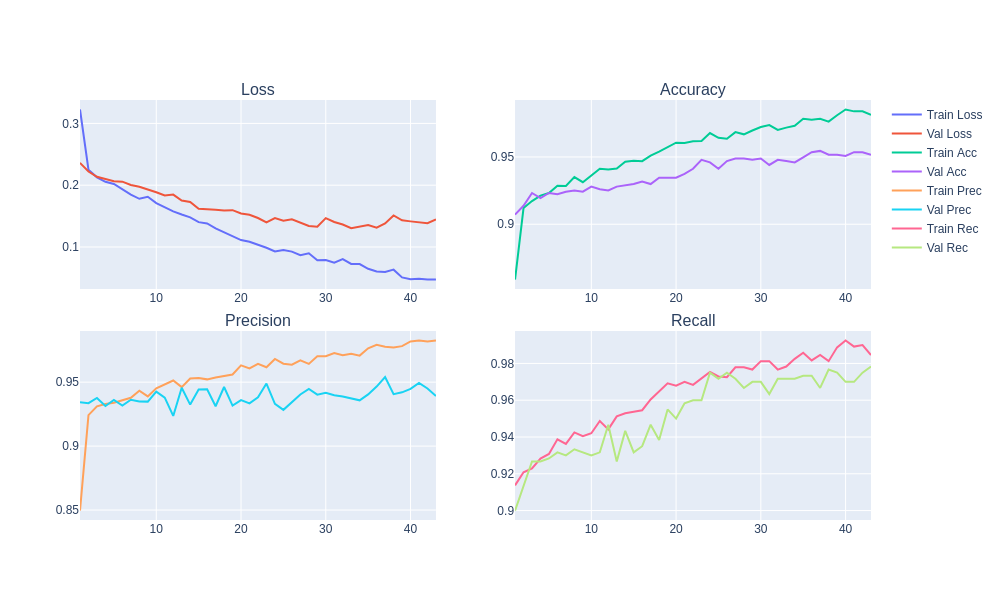

In [ ]:
# Plot training history
model3.plot_training_history()

## Model Performance Evaluation


### Evaluate All Models

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Model 1: NN with Class Weights PERFORMANCE ===
Accuracy: 0.7576
Precision: 0.5308
Recall: 0.7594
F1-Score: 0.6249
AUC-ROC: 0.8362

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82      1033
       Churn       0.53      0.76      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407



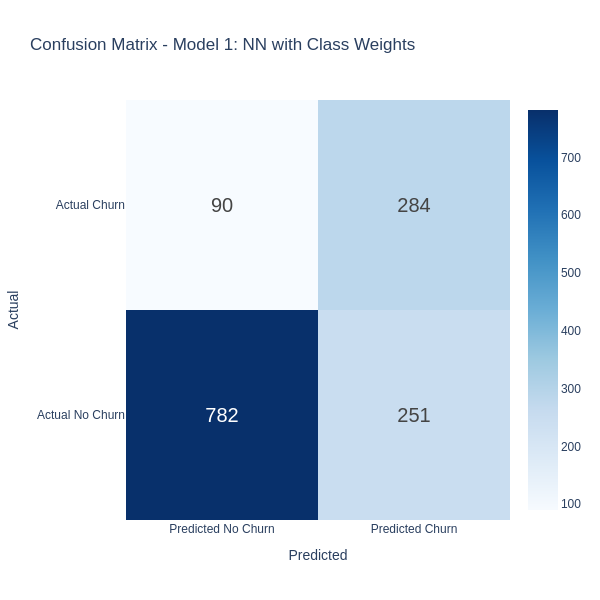


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Model 2: NN with SMOTETomek PERFORMANCE ===
Accuracy: 0.7569
Precision: 0.5343
Recall: 0.6658
F1-Score: 0.5929
AUC-ROC: 0.8134

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.79      0.83      1033
       Churn       0.53      0.67      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.76      1407



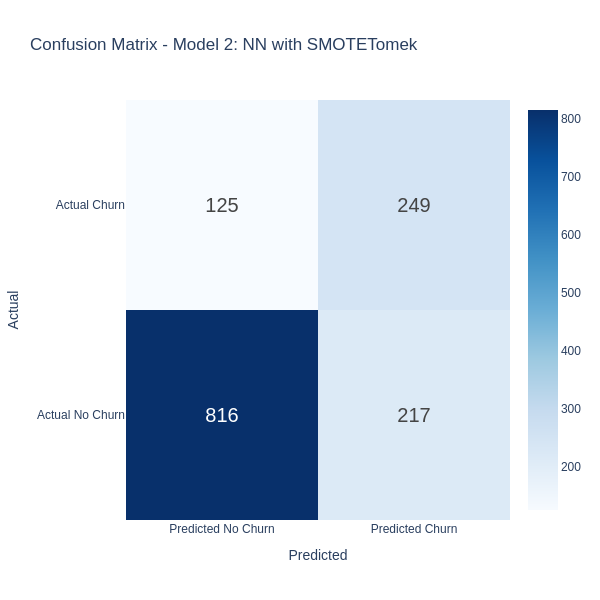


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Model 3: NN with SMOTEENN PERFORMANCE ===
Accuracy: 0.7200
Precision: 0.4842
Recall: 0.8182
F1-Score: 0.6083
AUC-ROC: 0.8126

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.68      0.78      1033
       Churn       0.48      0.82      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.72      0.74      1407



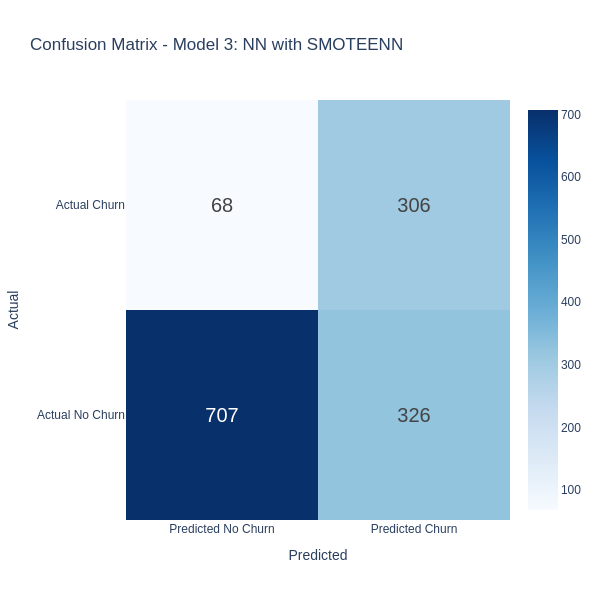


=== MODEL COMPARISON ===
           Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Class Weights    0.7576     0.5308  0.7594    0.6249   0.8362
1     SMOTETomek    0.7569     0.5343  0.6658    0.5929   0.8134
2       SMOTEENN    0.7200     0.4842  0.8182    0.6083   0.8126


In [ ]:

# Model 1: Class Weights
results1 = model1.evaluate_model(X_test_processed, y_test)
print()

# Model 2: SMOTETomek
results2 = model2.evaluate_model(X_test_processed, y_test)
print()

# Model 3: SMOTEENN
results3 = model3.evaluate_model(X_test_processed, y_test)
print()

### Model Comparison
comparison_df = pd.DataFrame({
    'Model': ['Class Weights', 'SMOTETomek', 'SMOTEENN'],
    'Accuracy': [results1['accuracy'], results2['accuracy'], results3['accuracy']],
    'Precision': [results1['precision'], results2['precision'], results3['precision']],
    'Recall': [results1['recall'], results2['recall'], results3['recall']],
    'F1-Score': [results1['f1'], results2['f1'], results3['f1']],
    'AUC-ROC': [results1['auc'], results2['auc'], results3['auc']]
})

print("=== MODEL COMPARISON ===")
print(comparison_df.round(4))

### Visualize Model Comparison

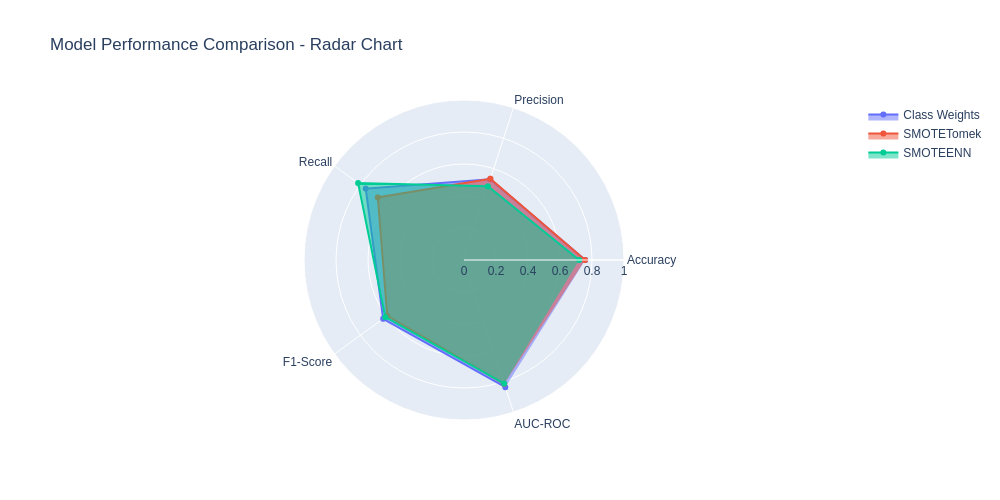


=== BEST MODEL ===
Best performing model: Class Weights
F1-Score: 0.6249


In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
fig = go.Figure()

for i, model_name in enumerate(comparison_df['Model']):
    fig.add_trace(go.Scatterpolar(
        r=[comparison_df.iloc[i][metric] for metric in metrics],
        theta=metrics,
        fill='toself',
        name=model_name
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    title="Model Performance Comparison - Radar Chart",
    height=500,
    width=1000
)

display_fig(fig)

# Determine best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.iloc[best_model_idx]['Model']
print(f"\n=== BEST MODEL ===")
print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {comparison_df.iloc[best_model_idx]['F1-Score']:.4f}")

## Hyperparameter Tuning

### Tuner Architecture

In [ ]:
# Install required packages (run this in your environment)
!pip install keras-tuner optuna -q
!pip install optuna-integration[tfkeras] -q

import keras_tuner as kt


In [ ]:
class TelcoChurnTuner:
    def __init__(self,
                 input_dim,
                 best_model_name,
                 model1, results1, X_train_processed, y_train, # Class Weights Model
                 model2, results3, X_train_sm, y_train_sm, X_val_sm, y_val_sm, # SMOTETomek
                 model3, results2, X_train_se, y_train_se, X_val_se, y_val_se # SMOTEENN
                 ):

        self.tuner = None
        self.input_dim = input_dim

        self.best_model_name = best_model_name
        self.best_base_model = None
        self.base_results = None
        self.X_train_best = None
        self.y_train_best = None
        self.X_val_best = None
        self.y_val_best = None
        self.use_class_weight = False

        self.validation_data = None
        self.validation_split = None

        # Class Weights Model
        self.model1 = model1
        self.results1 = results1
        self.X_train_processed = X_train_processed
        self.y_train = y_train
        # SMOTETomek
        self.model2 = model2
        self.results3 = results3
        self.X_train_sm = X_train_sm
        self.y_train_sm = y_train_sm
        self.X_val_sm = X_val_sm
        self.y_val_sm = y_val_sm
        # SMOTEENN
        self.model3 = model3
        self.results2 = results2
        self.X_train_se = X_train_se
        self.y_train_se = y_train_se
        self.X_val_se = X_val_se
        self.y_val_se = y_val_se

        self.best_model_tuned = None



    def build_model_kt(self, hp):
        """Build model with Keras Tuner hyperparameters"""

        model = models.Sequential()

        # First layer with tunable parameters
        model.add(layers.Dense(
            hp.Int('units_1', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', ['relu', 'selu']),
            input_shape=(self.input_dim,)
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

        # Variable number of hidden layers
        num_layers = hp.Int('num_layers', 2, 4)

        for i in range(num_layers - 1):
            model.add(layers.Dense(
                hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
                activation=hp.Choice(f'activation_{i+2}', ['relu', 'selu'])
            ))
            model.add(layers.Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.4, step=0.1)))

        # Output layer
        model.add(layers.Dense(1, activation='sigmoid'))

        # Compile with tunable learning rate and optimizer
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

        if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall', self.F1Score()]
        )

        return model



    def setup_tuner(self):
            print("\n=== KERAS TUNER CONFIGURATION ===")

            # Create tuner with F1-score as objective
            self.tuner = kt.RandomSearch(
                self.build_model_kt,
                objective=kt.Objective('val_f1_score', direction='max'),
                max_trials=25,
                executions_per_trial=2,  # Multiple executions for more robust results
                directory='keras_tuner_results',
                project_name='churn_prediction_tuning',
                overwrite=True
            )

            print("Search Space Configuration:")
            print("- First layer units: 32-256 (step: 32)")
            print("- Hidden layer units: 16-128 (step: 16)")
            print("- Number of layers: 2-4")
            print("- Dropout rates: 0.1-0.4 (step: 0.1)")
            print("- Learning rate: 1e-4 to 1e-2 (log scale)")
            print("- Optimizers: Adam, SGD")
            print("- Activations: ReLU, SELU")
            print(f"- Total trials: 25")
            print(f"- Executions per trial: 2")

            # Display search space summary
            print("-" * 40)
            self.tuner.search_space_summary()



    def select_best_model(self):
        if self.best_model_name == 'Class Weights':
            self.best_base_model = self.model1
            self.base_results = self.results1
            self.X_train_best = self.X_train_processed
            self.y_train_best = self.y_train
            self.X_val_best = None
            self.y_val_best = None
            self.use_class_weight = True
        elif self.best_model_name == 'SMOTETomek':
            self.best_base_model = self.model2
            self.base_results = self.results3
            self.X_train_best = self.X_train_sm
            self.y_train_best = self.y_train_sm
            self.X_val_best = self.X_val_sm
            self.y_val_best = self.y_val_sm
            self.use_class_weight = False
        else:  # SMOTEENN
            self.best_base_model = self.model3
            self.base_results = self.results2
            self.X_train_best = self.X_train_se
            self.y_train_best = self.y_train_se
            self.X_val_best = self.X_val_se
            self.y_val_best = self.y_val_se
            self.use_class_weight = False

        print(f"=== HYPERPARAMETER TUNING FOR {self.best_model_name.upper()} ===")



    def prepare_data(self):
        # Prepare validation data
        if self.X_val_best is not None:
            self.validation_data = (self.X_val_best, self.y_val_best)
            self.validation_split = None
            print(f"\nUsing predefined validation set: {self.X_val_best.shape[0]} samples")
        else:
            self.validation_data = None
            self.validation_split = 0.2
            print(f"\nUsing validation split: 20% of training data")

        print(f"Training samples: {self.X_train_best.shape[0]}")
        print(f"Training features: {self.X_train_best.shape[1]}")



    def execute_hyperparameter_search(self):
        print("\n=== STARTING HYPERPARAMETER SEARCH ===")
        print("This may take a while depending on your hardware...")


        # Define class weight if used
        class_weight = None
        if self.use_class_weight:
            class_weights = compute_class_weight(
                'balanced',
                classes=np.unique(self.y_train_best),
                y=self.y_train_best
            )
            class_weight = {0: class_weights[0], 1: class_weights[1]}

        # Define callbacks for training
        search_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_f1_score',
                patience=5,
                mode='max',
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                patience=3,
                factor=0.5,
                min_lr=1e-7
            )
        ]

        # Start the search
        self.tuner.search(
            self.X_train_best, self.y_train_best,
            epochs=50,
            batch_size=32,
            validation_data = self.validation_data,
            validation_split = self.validation_split,
            class_weight = class_weight,
            callbacks = search_callbacks,
            verbose = 1
        )

        print("\nHyperparameter search completed!")



    def analyze_results(self):
        print("\n=== TUNING RESULTS ANALYSIS ===")

        # Get best hyperparameters
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]

        print("Best Hyperparameters Found:")
        print("-" * 40)
        for param, value in best_hps.values.items():
            print(f"{param:20}: {value}")

        # Get best models
        best_models = self.tuner.get_best_models(num_models=3)
        print(f"\nTop 3 models retrieved successfully")

        # Display the best model (top 1) architecture
        print("\nBest Model Architecture:")
        print("-" * 40)
        self.best_model_tuned = best_models[0]
        self.best_model_tuned.summary()



    def train_final_tuned_model(self):
        print("\n=== TRAINING FINAL TUNED MODEL ===")

        # Put the best model into a new TelcoChurnNeuralNetwork object
        input_dim = self.X_train_best.shape[1]
        self.best_model_tuned = TelcoChurnNeuralNetwork(input_dim, title="Final Tuned Model", model=self.best_model_tuned)

        # Train with optimal hyperparameters
        self.best_model_tuned.train_model(
            self.X_train_best, self.y_train_best,
            validation_data = self.validation_data,
            validation_split = self.validation_split,
            using_class_weight = self.use_class_weight
        )

        print("\n=== Final model training completed! ===\n")

        # Plot training history for tuned model
        self.best_model_tuned.plot_training_history()



    class F1Score(tf.keras.metrics.Metric):
        """Custom F1 Score metric for Keras Tuner optimization"""

        def __init__(self, name='f1_score', **kwargs):
            super().__init__(name=name, **kwargs)
            self.precision = tf.keras.metrics.Precision()
            self.recall = tf.keras.metrics.Recall()

        def update_state(self, y_true, y_pred, sample_weight=None):
            self.precision.update_state(y_true, y_pred, sample_weight)
            self.recall.update_state(y_true, y_pred, sample_weight)

        def result(self):
            precision = self.precision.result()
            recall = self.recall.result()
            return 2 * ((precision * recall) / (precision + recall + 1e-6))

        def reset_state(self):
            self.precision.reset_state()
            self.recall.reset_state()


### Running the Tuner

In [ ]:
tuner = TelcoChurnTuner(
        input_dim = input_dim,
        best_model_name = best_model_name,
        model1 = model1,
        results1 = results1,
        X_train_processed = X_train_processed,
        y_train = y_train,
        model2 = model2,
        results3 = results3,
        X_train_sm = X_train_sm,
        y_train_sm = y_train_sm,
        X_val_sm = X_val_sm,
        y_val_sm = y_val_sm,
        model3 = model3,
        results2 = results2,
        X_train_se = X_train_se,
        y_train_se = y_train_se,
        X_val_se = X_val_se,
        y_val_se = y_val_se
    )

#### Select the Best Model for Tuning (based on F1-score)

In [ ]:
tuner.select_best_model()

=== HYPERPARAMETER TUNING FOR CLASS WEIGHTS ===


#### Set Up Keras Tuner

In [ ]:
tuner.setup_tuner()


=== KERAS TUNER CONFIGURATION ===
Search Space Configuration:
- First layer units: 32-256 (step: 32)
- Hidden layer units: 16-128 (step: 16)
- Number of layers: 2-4
- Dropout rates: 0.1-0.4 (step: 0.1)
- Learning rate: 1e-4 to 1e-2 (log scale)
- Optimizers: Adam, SGD
- Activations: ReLU, SELU
- Total trials: 25
- Executions per trial: 2
----------------------------------------
Search space summary
Default search space size: 9
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu'], 'ordered': False}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampli

#### Prepare Training Data for Keras Tuner

In [ ]:
tuner.prepare_data()


Using validation split: 20% of training data
Training samples: 5625
Training features: 23


#### Execute Hyperparameter Search

In [ ]:
tuner.execute_hyperparameter_search()

Trial 25 Complete [00h 00m 46s]
val_f1_score: 0.6575760543346405

Best val_f1_score So Far: 0.6580957174301147
Total elapsed time: 00h 18m 30s

Hyperparameter search completed!


#### Analyze Tuning Results

In [ ]:
tuner.analyze_results()


=== TUNING RESULTS ANALYSIS ===
Best Hyperparameters Found:
----------------------------------------
units_1             : 160
activation          : selu
dropout_1           : 0.1
num_layers          : 2
units_2             : 16
activation_2        : selu
dropout_2           : 0.1
optimizer           : adam
learning_rate       : 0.005553415568099142
units_3             : 80
activation_3        : relu
dropout_3           : 0.1
units_4             : 112
activation_4        : selu
dropout_4           : 0.1

Top 3 models retrieved successfully

Best Model Architecture:
----------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

#### Train Final Tuned Model


=== TRAINING FINAL TUNED MODEL ===

=== TRAINING CONFIGURATION ===
Input dimension: 23
Epochs: 50
Batch size: 32
Validation split: 0.2
Class weights: {0: np.float64(0.6809927360774818), 1: np.float64(1.8812709030100334)}
Early stopping callback: used
Reduce learning rate callback: used

=== MODEL SUMMARY ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7467 - f1_score: 0.6221 - loss: 0.5045 - precision: 0.5246 - recall: 0.7657 - val_accuracy: 0.7902 - val_f1_score: 0.6509 - val_loss: 0.4361 - val_precision: 0.5729 - val_recall: 0.7534 - learning_rate: 0.0056
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7472 - f1_score: 0.6239 - loss: 0.5053 - precision: 0.5249 - recall: 0.7699 - val_accuracy: 0.7858 - val_f1_score: 0.6482 - val_loss: 0.4417 - val_precision: 0.5649 - val_recall: 0.7603 - learning_rate: 0.0056
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - f1_score: 0.6292 - loss: 0.5011 - precision: 0.5346 - recall: 0.7654 - val_accuracy: 0.7822 - val_f1_score: 0.6402 - val_loss: 0.4408 - val_precision: 0.5604 - val_recall: 0.7466 - learning_rate: 0.0056
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7561 - f1_score: 0.6335 - loss: 0.4986 - precision: 0.5366 - recall: 0.7738 - val_accuracy: 0.7876 - val

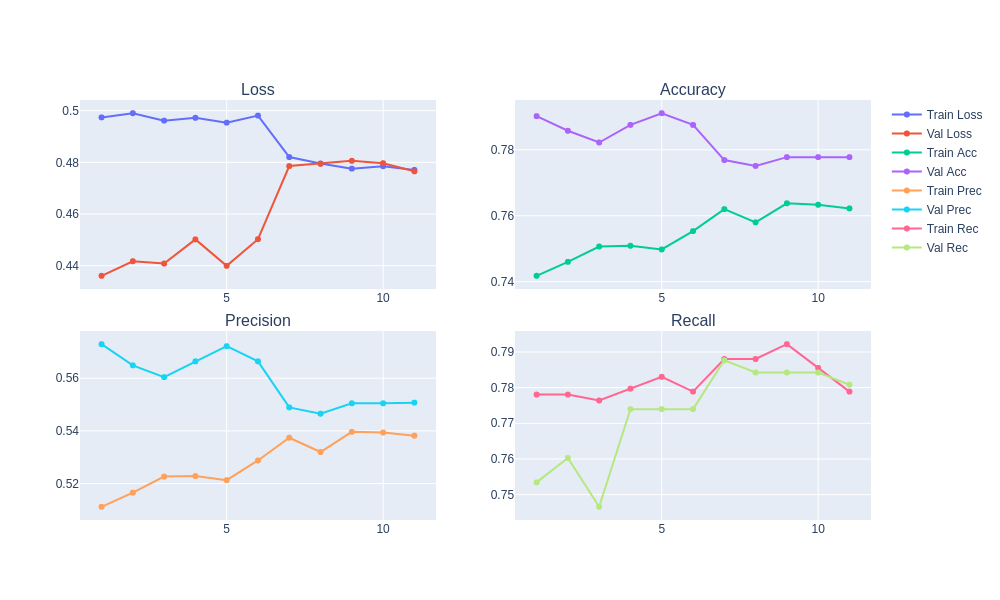

In [ ]:
tuner.train_final_tuned_model()

## Model Performance Comparison

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== Final Tuned Model PERFORMANCE ===
Accuracy: 0.7711
Precision: 0.5528
Recall: 0.7273
F1-Score: 0.6282
AUC-ROC: 0.8318

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.83      1033
       Churn       0.55      0.73      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



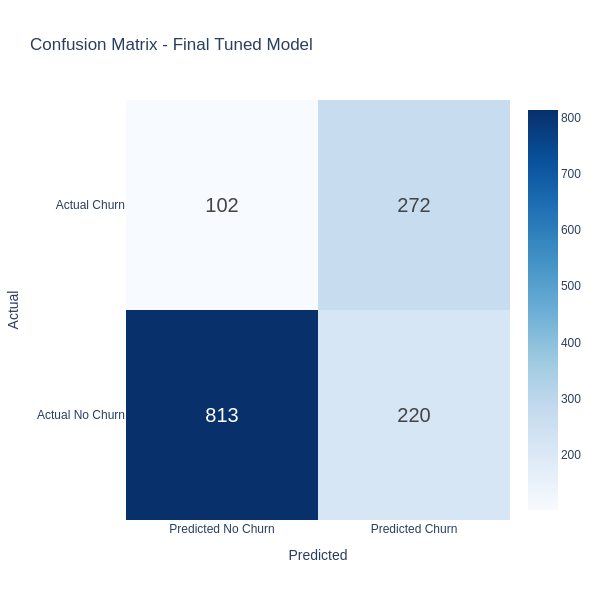


Detailed Performance Comparison:
   Metric  Base Model  Tuned Model  Improvement (%)  Difference
 Accuracy    0.757640     0.771144             1.78      0.0135
Precision    0.530841     0.552846             4.15      0.0220
   Recall    0.759358     0.727273            -4.23     -0.0321
 F1-Score    0.624862     0.628176             0.53      0.0033
  AUC-ROC    0.836192     0.831847            -0.52     -0.0043


In [ ]:
# Evaluate tuned model
tuned_results = tuner.best_model_tuned.evaluate_model(X_test_processed, y_test)

# Create detailed comparison
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Base Model': [
        tuner.base_results['accuracy'],
        tuner.base_results['precision'],
        tuner.base_results['recall'],
        tuner.base_results['f1'],
        tuner.base_results['auc']
    ],
    'Tuned Model': [
        tuned_results['accuracy'],
        tuned_results['precision'],
        tuned_results['recall'],
        tuned_results['f1'],
        tuned_results['auc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement (%)'] = ((comparison_df['Tuned Model'] - comparison_df['Base Model']) / comparison_df['Base Model'] * 100).round(2)
comparison_df['Difference'] = (comparison_df['Tuned Model'] - comparison_df['Base Model']).round(4)

print("\nDetailed Performance Comparison:")
print("=" * 63)
print(comparison_df.to_string(index=False))

In [ ]:
# Store final results for next sections
final_model = tuner.best_model_tuned
final_results = tuned_results
final_model.model.save('best_model.keras')